In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    stype = torch.float
    buftype = torch.float
    randtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias, 
                              stype=stype, buftype=buftype, randtype=randtype).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, randtype=randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.9070003032684326 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010324073024094105 max: -0.0013859625905752182 RMSE:  0.006298381369560957
error distribution=========>


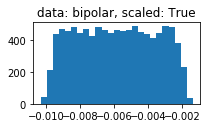

progressive accuracy=========>


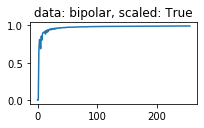

--- 0.9420003890991211 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.27130126953125 max: 0.1015625 RMSE:  0.3153287172317505
error distribution=========>


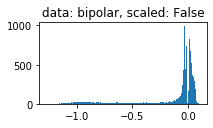

progressive accuracy=========>


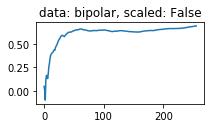

--- 1.007000207901001 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005529746413230896 max: -0.0012524425983428955 RMSE:  0.0035574522335082293
error distribution=========>


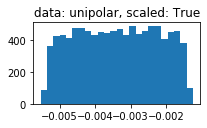

progressive accuracy=========>


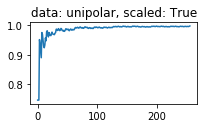

--- 1.1779990196228027 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


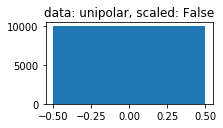

progressive accuracy=========>


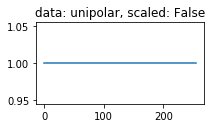

In [5]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.387998342514038 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010574281215667725 max: -0.0012715645134449005 RMSE:  0.006427771411836147
error distribution=========>


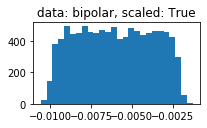

progressive accuracy=========>


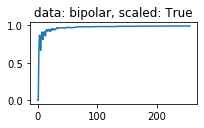

--- 1.3609981536865234 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -1.4921875 max: 0.7299346923828125 RMSE:  0.33704978227615356
error distribution=========>


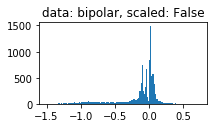

progressive accuracy=========>


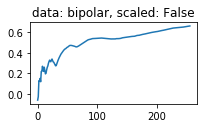

--- 0.8579990863800049 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005749359726905823 max: -0.0013605058193206787 RMSE:  0.003739077365025878
error distribution=========>


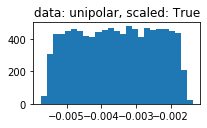

progressive accuracy=========>


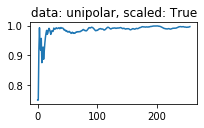

--- 0.5570018291473389 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


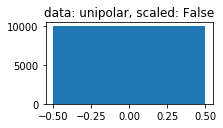

progressive accuracy=========>


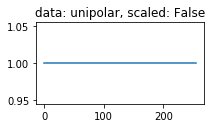

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8059995174407959 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010400217957794666 max: -0.0010786745697259903 RMSE:  0.006209856830537319
error distribution=========>


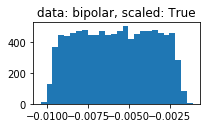

progressive accuracy=========>


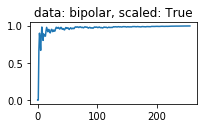

--- 0.7809996604919434 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8984375 max: 1.6484375 RMSE:  0.5512940883636475
error distribution=========>


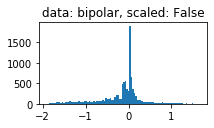

progressive accuracy=========>


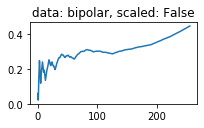

--- 0.5509986877441406 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005466282367706299 max: -0.001202702522277832 RMSE:  0.003546221647411585
error distribution=========>


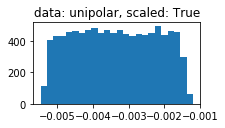

progressive accuracy=========>


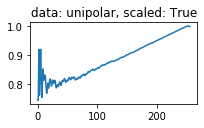

--- 0.7769994735717773 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


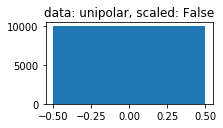

progressive accuracy=========>


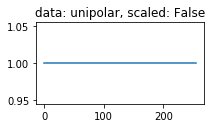

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.114999771118164 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010478207841515541 max: -0.0015182346105575562 RMSE:  0.006400394719094038
error distribution=========>


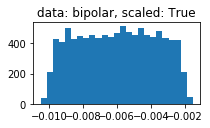

progressive accuracy=========>


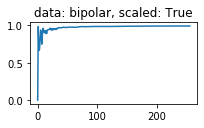

--- 0.8449993133544922 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.38037109375 max: 0.2578125 RMSE:  0.3212248384952545
error distribution=========>


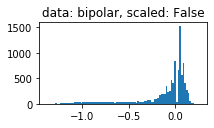

progressive accuracy=========>


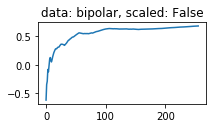

--- 0.5690000057220459 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005617976188659668 max: -0.0012614727020263672 RMSE:  0.003623245982453227
error distribution=========>


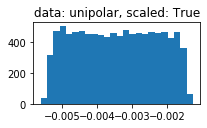

progressive accuracy=========>


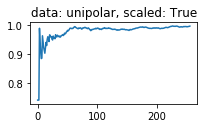

--- 0.5770001411437988 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


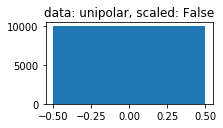

progressive accuracy=========>


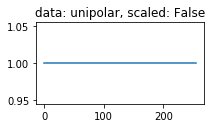

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)